# Product Recognition on Store Shelves

In [1]:
print(":|")

:|


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import itertools

In [3]:
def print_image_path(image_path):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

def print_image(image, type='bgr'):
    if type == 'bgr':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif type == 'gray':
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    plt.imshow(image)
    plt.axis('off')  # Optional: Turn off axis labels and ticks
    plt.show()

## STEP A - Multiple Product Detection

Develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. The system should be able to correctly identify all the product in the shelves image.

* The images with the products that must be detected are: *models/{0,1,11,19,24,25,26}.jpg*
* The test images are: *scenes/e{1,2,3,4,5}.png*

Let's detect keypoints in two images, a product and a scene, as an example.

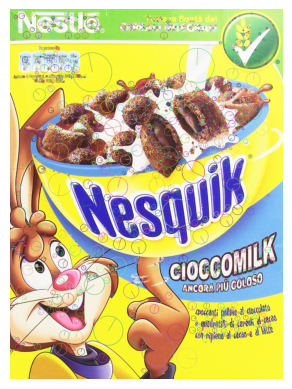

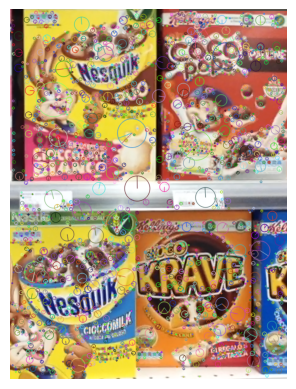

model kp len: 2694
scene kp len: 3264


In [4]:
# Load the query and the train images
model_im = cv2.imread('models/0.jpg')
scene_im = cv2.imread('scenes/e4.png')

# Creating SIFT object
sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=20, sigma=3.1)

# Detecting Keypoints in the
md_kp = sift.detect(model_im)
sc_kp = sift.detect(scene_im)

# Visualizing the found Keypoints
md_with_kp = cv2.drawKeypoints(model_im,md_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(md_with_kp)

sc_with_kp = cv2.drawKeypoints(scene_im,sc_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(sc_with_kp)

print("model kp len: {}".format(len(md_kp)))
print("scene kp len: {}".format(len(sc_kp)))

With the following code (we could erase this since it will be part of the system....) we find the product in the scene, calculate the homography, and print the bounding box of the product.

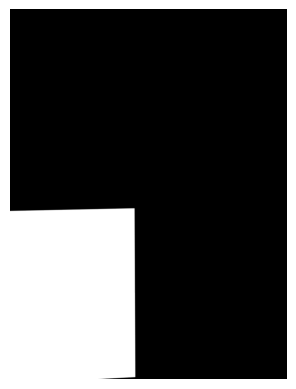

[[ 8322.]
 [26828.]
 [13940.]
 [41954.]
 [ 4659.]
 [ 7705.]
 [ 2531.]
 [  790.]
 [  653.]
 [  571.]
 [  400.]
 [  597.]
 [ 2345.]
 [11997.]
 [ 8855.]
 [ 5802.]
 [  689.]
 [  332.]
 [  280.]
 [  233.]
 [  384.]
 [  596.]
 [ 1040.]
 [    0.]
 [    0.]
 [    0.]
 [    0.]
 [    0.]
 [    0.]
 [    0.]
 [    0.]
 [    0.]]
[[[ -5 522]]

 [[ -1 967]]

 [[322 950]]

 [[320 515]]]


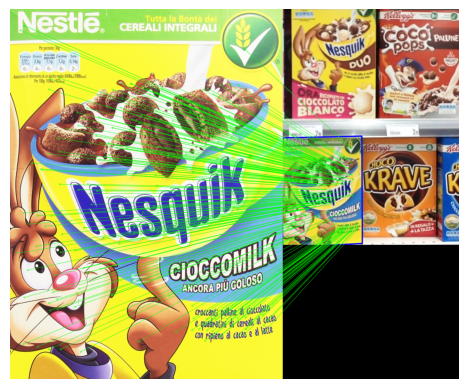

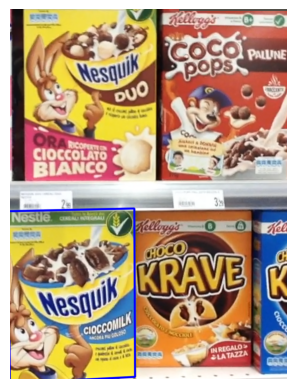

In [5]:
# Computing the descriptors for each keypoint
kp_model, des_model = sift.compute(model_im, md_kp)
kp_scene, des_scene = sift.compute(scene_im, sc_kp)

# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(des_model,des_scene,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)



# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = model_im.shape[0:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    mask = np.zeros_like(scene_im[:,:,0])
    #mask = cv2.polylines(mask,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    mask = cv2.fillPoly(mask,[np.int32(dst)],255, cv2.LINE_AA)
    print_image(mask, 'gray')
    # Drawing bounding box
    scene_im = cv2.polylines(scene_im,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    hsv = cv2.cvtColor(scene_im, cv2.COLOR_BGR2HSV)
    masked = cv2.bitwise_and(scene_im,scene_im,mask = mask)
    hist = cv2.calcHist([hsv], [0], mask, [32], [0,256])
    print(hist)
    print(np.int32(dst))
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(model_im,md_kp,scene_im,sc_kp,good,None,**draw_params)
print_image(img3)
print_image(scene_im)

# PROVE

In [6]:
'''from math import radians, cos, sin
accumulator = Hough_Accumulator(scene_im)

prod_st = Product_Model_GHT(0, kp_model, des_model)
# Matching the descriptors
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(des_model,des_scene,k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

bins = []
for match in good:
    y,x,s,r = accumulator.accumulate(prod_st.keypoints[match.queryIdx], kp_scene[match.trainIdx])
    bins.append((y,x,s,r))

max_point = np.unravel_index(accumulator.accumulator.argmax(), accumulator.accumulator.shape)

max_val = accumulator.accumulator.max()

y,x,s,r = max_point
ght_match = []
src_pts = []
dst_pts = []
i = 0
for bin in bins:
    if bin == (y,x,s,r):
        #ght_match.append(match)
        src_pts.append(kp_model[good[i].queryIdx].pt)
        dst_pts.append(kp_scene[good[i].trainIdx].pt)
    i+=1
#print(src_pts)

if len(dst_pts) < 8: print("AAAAAAAAAAAAAAAHHHH")

src_pts = np.float32(src_pts).reshape(-1,1,2)
dst_pts = np.float32(dst_pts).reshape(-1,1,2)
# Calculating homography based on correspondences
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Apply homography to project corners of the query image into the image
h,w = model_im.shape[0:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
print("shape: {}".format(np.int32(dst)))
#r_list.append(dst)

#return dst, max_val, max_point#, kp, des

## create a string for the final report
str = ""

# scene image with products bounding box
scene_bbox = scene_im.copy()


if len(dst) > 0:
    
    # Drawing bounding box
    str += "Product {} - {} instance found:\n".format(prod_st.id, len(dst))

    print(dst)
    scene_bbox = cv2.polylines(scene_bbox,np.int32(dst),True,(255,0,0),3, cv2.LINE_AA)
    #scene_bbox = cv2.polylines(scene_bbox,np.int32([[[0,0]],[[0,50]],[[50,50]],[[50,0]]]),True,(255,0,0),3, cv2.LINE_AA)
    print_image(scene_bbox)'''

'from math import radians, cos, sin\naccumulator = Hough_Accumulator(scene_im)\n\nprod_st = Product_Model_GHT(0, kp_model, des_model)\n# Matching the descriptors\nmatcher = cv2.BFMatcher()\nmatches = matcher.knnMatch(des_model,des_scene,k=2)\n\n# Keeping only good matches as per Lowe\'s ratio test.\ngood = []\nfor m,n in matches:\n    if m.distance < 0.8*n.distance:\n        good.append(m)\n\nbins = []\nfor match in good:\n    y,x,s,r = accumulator.accumulate(prod_st.keypoints[match.queryIdx], kp_scene[match.trainIdx])\n    bins.append((y,x,s,r))\n\nmax_point = np.unravel_index(accumulator.accumulator.argmax(), accumulator.accumulator.shape)\n\nmax_val = accumulator.accumulator.max()\n\ny,x,s,r = max_point\nght_match = []\nsrc_pts = []\ndst_pts = []\ni = 0\nfor bin in bins:\n    if bin == (y,x,s,r):\n        #ght_match.append(match)\n        src_pts.append(kp_model[good[i].queryIdx].pt)\n        dst_pts.append(kp_scene[good[i].trainIdx].pt)\n    i+=1\n#print(src_pts)\n\nif len(dst_pts)

model kpoints: 157


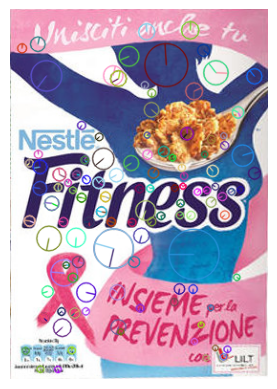

scene kpoints: 2411


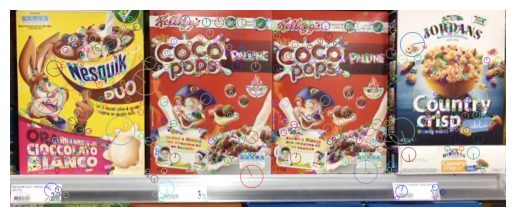

Time elapsed for matching: 0.002304341000126442
Not enough matches are found - 1/37


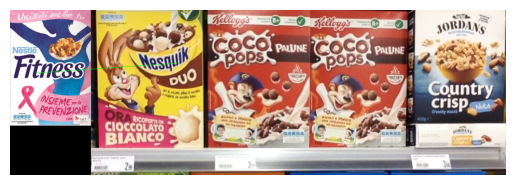

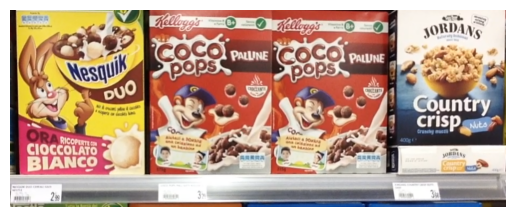

In [7]:
from timeit import default_timer as timer

use_flann = False

# Load the query and the train images
model_im = cv2.imread('models/24.jpg')
scene_im = cv2.imread('scenes/m3.png')

# Creating SIFT object
sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=10, sigma=5.6)
sift_s = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=2.6)

# this is fine! sometimes it works good
# sift_m = sift_s = cv2.SIFT_create(nOctaveLayers=6, contrastThreshold=0.16, edgeThreshold=15, sigma=1.6)


# Detecting Keypoints in the
md_kp = sift_m.detect(model_im)
sc_kp = sift_s.detect(scene_im)

# Visualizing the found Keypoints
md_with_kp = cv2.drawKeypoints(model_im,md_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("model kpoints: {}".format(len(md_kp)))
print_image(md_with_kp)

sc_with_kp = cv2.drawKeypoints(scene_im,sc_kp,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print("scene kpoints: {}".format(len(sc_kp)))
print_image(sc_with_kp)


# Computing the descriptors for each keypoint
kp_model, des_model = sift_m.compute(model_im, md_kp)
kp_scene, des_scene = sift_s.compute(scene_im, sc_kp)

# timing the matching to compare flann with brute force
t_start = timer()
# Initializing the matching algorithm
if use_flann:
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50, cores = 4)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching the descriptors
    matches = flann.knnMatch(des_model,des_scene,k=2)
else:
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_model,des_scene,k=2)

t_end = timer()
print("Time elapsed for matching: {}".format(t_end-t_start))

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)



# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 200
if len(good) > (int(0.24*len(kp_model))):
    print("Found {} matches".format(len(good)))
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = model_im.shape[0:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing bounding box
    scene_im = cv2.polylines(scene_im,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), (int(0.24*len(kp_model)))) )
    matchesMask = None


# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(model_im,md_kp,scene_im,sc_kp,good,None,**draw_params)
print_image(img3)
print_image(scene_im)

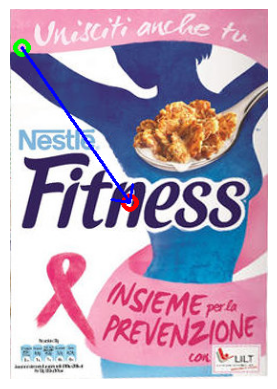

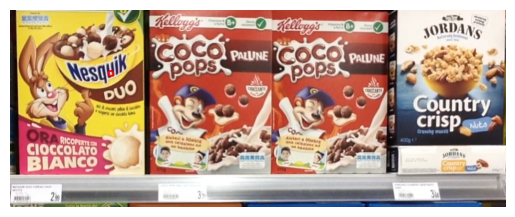

In [8]:
centroid_model = np.float32([ kp.pt for kp in md_kp ]).reshape(-1,1,2).mean(axis=0, dtype=np.int32)[0]

vect = centroid_model - kp_model[0].pt

centroid_im = cv2.circle(model_im.copy(), centroid_model, 7, (0,0,255), 3)
centroid_im = cv2.circle(centroid_im, np.int32(kp_model[0].pt), 7, (0,255,0), 3)
centroid_im = cv2.arrowedLine(centroid_im, np.int32(kp_model[0].pt), np.int32(kp_model[0].pt + vect), (255,0,0), 2)

print_image(centroid_im)

centroid_scene = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2).mean(axis=0, dtype=np.int32)[0]

centroid_im2 = cv2.circle(scene_im.copy(), centroid_scene, 7, (0,0,255), 3)
print_image(centroid_im2)

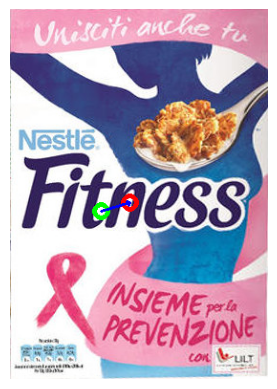

337.02161407470703
0.4481196320518163
[29.77839661 -9.63900757]


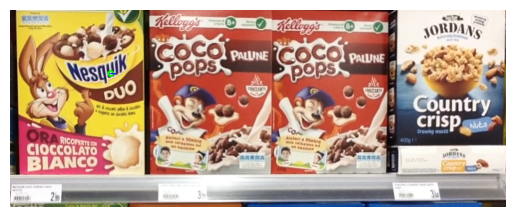

'\n#print(des_model[t_idx])\n#print(des_scene[q_idx])\nprint(kp_model[q_idx].pt)\nprint(kp_scene[t_idx].pt)\n\nimg1 = cv2.drawKeypoints(model_im,[kp_model[q_idx]],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\nprint_image(img1)\n\nimg2 = cv2.drawKeypoints(scene_im,[kp_scene[t_idx]],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\nprint_image(img2)\n\nprint(kp_model[q_idx].size)\nprint(kp_scene[t_idx].size)'

In [9]:
from cv2 import KeyPoint
from math import cos, sin, radians, degrees
idx = 0

q_idx = good[idx].queryIdx
t_idx = good[idx].trainIdx

centroid_model = np.float32([ kp.pt for kp in md_kp ]).reshape(-1,1,2).mean(axis=0, dtype=np.int32)[0]

vect = np.array(centroid_model - kp_model[q_idx].pt)

centroid_im = cv2.circle(model_im.copy(), centroid_model, 7, (0,0,255), 3)
centroid_im = cv2.circle(centroid_im, np.int32(kp_model[q_idx].pt), 7, (0,255,0), 3)
centroid_im = cv2.arrowedLine(centroid_im, np.int32(kp_model[q_idx].pt), np.int32(kp_model[q_idx].pt + vect), (255,0,0), 2)

print_image(centroid_im)

centroid_im2 = cv2.circle(scene_im.copy(), np.int32(kp_scene[t_idx].pt), 7, (0,255,0), 3)
p1_sc = np.int32(kp_scene[t_idx].pt)
scale_f = kp_scene[t_idx].size / kp_model[q_idx].size
rot_f = kp_scene[t_idx].angle - kp_model[q_idx].angle
rot_f = radians(rot_f)

print(degrees(rot_f))
print(scale_f)
print(vect)


ccos = cos(rot_f)
ssin = sin(rot_f)
vect_r = np.float32([[ccos, ssin],[-ssin,ccos]])

#print(vect_r)
centr_2 = np.int32(p1_sc + scale_f*(vect_r.dot(vect)))

centroid_im2 = cv2.arrowedLine(centroid_im2, p1_sc, centr_2, (255,0,0), 2)

print_image(centroid_im2)

'''
#print(des_model[t_idx])
#print(des_scene[q_idx])
print(kp_model[q_idx].pt)
print(kp_scene[t_idx].pt)

img1 = cv2.drawKeypoints(model_im,[kp_model[q_idx]],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(img1)

img2 = cv2.drawKeypoints(scene_im,[kp_scene[t_idx]],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print_image(img2)

print(kp_model[q_idx].size)
print(kp_scene[t_idx].size)'''

In [10]:
a = np.array([10,10])
ccos = cos(radians(15))
ssin = sin(radians(15))
#b = np.array([[ccos, -ssin],[ssin,ccos]]) #anticlockwise
b = np.array([[ccos, ssin],[-ssin,ccos]]) #clockwise rotation
b.dot(a)

array([12.24744871,  7.07106781])

### Step A - Some utility functions

In [11]:
# CONSTANTS used for images, keypoints, descriptors (returned by get_keypoints_and_descriptors())
ID = 0
KP = 1
DES = 2
HUE = 3

# CONSTANTS used for width, heigth and centroid of objects found in the scene (returned by find_match())
CENTER = 0
WIDTH = 1
HEIGHT = 2


def extract_id_from_path(string):
    '''
    Given a full or local path of a file, it extracts the filename excluding the extension.

    Args:
        string: a path string such as "model/0.jpg" or "e1.jpg"

    Returns:
        string: the name of the file without the extension
    '''

    if "/" in string:
        string = string.split('/')[-1]
    if "." in string:
        string = string.split('.')[0]
    return string


def get_keypoints_and_descriptors(paths_im, sift, mask=None):
    '''
    Given a list of image paths and a mask, the method detects the keypoints and compute
    their descriptors. It returns a specific tuple.

    Args:
        paths_im:   paths of the images
        mask:       mask that filters the space in which to search for keypoints

    Returns:
        prod_st:    list of tuples - (product_id, keypoint, description)
                        the product_id is extracted by the image filename.
        images:     list of the images read by disk
    '''

    if sift is None:
        # create the SIFT object and the Flann matcher
        sift = cv2.SIFT_create()

    prod_st = []        # empty list for the informations (id, keypoints, description)
    images = []         # empty list for the images
    for path in paths_im:
        im = cv2.imread(path)
        images.append(im)

        kp, des = sift.detectAndCompute(im, mask)
        product_id = extract_id_from_path(path)

        # append to the list a tuple that describes the product
        prod_st.append([product_id, kp, des])
    
    return prod_st, images


def extract_product_position(points):

    # calculate central position of the object
    c_obj = tuple(np.int32(points.mean(axis=0)).ravel())
    
    # width of the object (euclidean norm of the vector)
    w_obj = int(np.linalg.norm(points[1].ravel() - points[2].ravel()))
    
    # height of the object (euclidean norm of the vector)
    h_obj = int(np.linalg.norm(points[0].ravel() - points[1].ravel()))
    
    return (c_obj, w_obj, h_obj)

### Step A - The system

The class Simple_Finder will be used to perform a the detection of multiple products in a scene image.

In [12]:
class Simple_Finder:

    def __init__(self, paths_im, use_flann=False):
        '''
        Saves the images and their descriptors (id, kp, des) in local structures, to improve the 
        reusability of the data during the detection process. It also initialize the Flann matcher.
        '''
        if use_flann:
            self.matcher = self.initialize_flann()
        else:
            self.matcher = cv2.BFMatcher()
        #self.sift = cv2.SIFT_create(contrastThreshold=0.03, edgeThreshold=10, sigma=2.3)
        self.sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=6, contrastThreshold=0.09, edgeThreshold=10, sigma=5.6)
        self.sift_s = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=2.6)
        self.lowe_ratio_distance = 0.8
        self.MIN_MATCH_COUNT = 30
        self.MIN_MATCH_PERC = 0.24
        
        self.prods_st, self.images = get_keypoints_and_descriptors(paths_im, self.sift_m, mask=None)


    def initialize_flann(self):
        '''Initializes the flann matcher with some default parameters'''
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        return cv2.FlannBasedMatcher(index_params, search_params)


    def find_match(self, product_st, scene_st, image):
        '''
        Given the KEYPOINTS, DESCRIPTIONS, IMAGE of model and train image (Product and Scene), 
        the function tries to find if the model is present in the train image

        Args:
            product_st:     the structure (id,kp,des) of the products
            scene:          the structure (id,kp,des) of the scene
            image:          product's image

        Returns:
            r_list:         list of coordinates of products mapped in the scene
        '''

        r_list = []

        # Matching the descriptors
        matches = self.matcher.knnMatch(product_st[DES],scene_st[DES],k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < self.lowe_ratio_distance*n.distance:
                good.append(m)

        # If we have matched at least the 70% of the model's keypoints we find the box of the object
        if len(good) > (self.MIN_MATCH_PERC*len(product_st[KP])):
            src_pts = np.float32([ product_st[KP][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ scene_st[KP][m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            
            # Calculating homography based on correspondences
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            
            # Apply homography to project corners of the query image into the image
            h,w = image.shape[0:2]
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            r_list.append(dst)

        return r_list


    def analyze_scene(self, path_scene):
        '''
        Given the path of a scene, the function searches for 
        the products in the scene by calling find_match().

        Args:
            path_scene: optional - paths of the scene image source

        Returns:
            description:    a string description of which products were found in the scene
            scene_bbox:     the scene image with the bounding box around the detected products
        '''

        if path_scene is None:
            print("ERROR: you must provide the path of a scene, to analyze it")
            return
        
        # get the keypoints and descriptors of the scene image
        scene_st, scene_im = get_keypoints_and_descriptors([path_scene], self.sift_s, None)
        # the method provides a list, but we analyze one image -> get the first element.
        scene_st = scene_st[0]
        scene_im = scene_im[0]

        ## create a string for the final report
        str = ""
        
        # scene image with products bounding box
        scene_bbox = scene_im.copy()

        for i in range(len(self.images)):
            
            # search for a single product in the scene
            points_in_scene = self.find_match(self.prods_st[i], scene_st, self.images[i])

            # Drawing bounding box
            for instance in points_in_scene:
                scene_bbox = cv2.polylines(scene_bbox,[np.int32(instance)],True,255,3, cv2.LINE_AA)
                found_pos = extract_product_position(instance)
                str += "Product {} - {} instance found:\n".format(self.prods_st[i][ID], len(points_in_scene))
                str += "\tInstance {} {{position: {}, width: {}px, height: {}px}}\n".format(len(found_pos), found_pos[CENTER], found_pos[WIDTH], found_pos[HEIGHT])

        return str, scene_bbox


### Step A - execution
The following code performs the main execution of the Step A activity. A report containing a description of each product found in every scene will be printed and saved on disk.

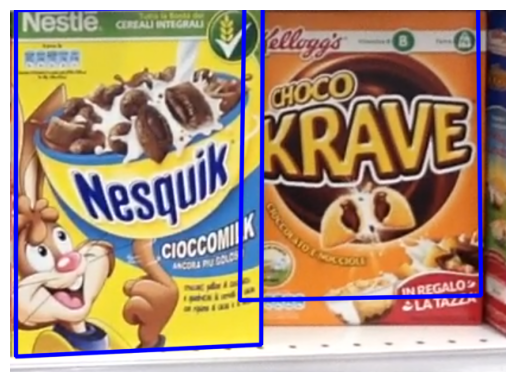

Scene: scenes/e1.png:
Product 0 - 1 instance found:
	Instance 3 {position: (162, 214), width: 309px, height: 437px}
Product 11 - 1 instance found:
	Instance 3 {position: (443, 170), width: 305px, height: 392px}




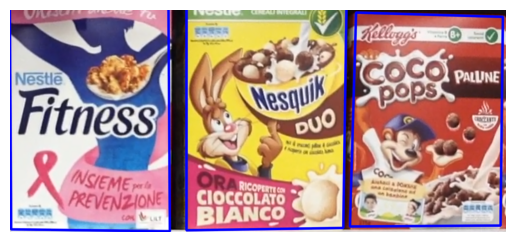

Scene: scenes/e2.png:
Product 24 - 1 instance found:
	Instance 3 {position: (167, 219), width: 334px, height: 490px}
Product 25 - 1 instance found:
	Instance 3 {position: (878, 233), width: 317px, height: 449px}
Product 26 - 1 instance found:
	Instance 3 {position: (538, 218), width: 330px, height: 490px}




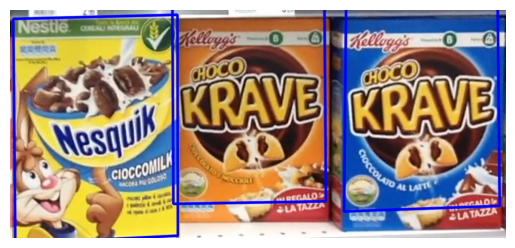

Scene: scenes/e3.png:
Product 0 - 1 instance found:
	Instance 3 {position: (171, 235), width: 323px, height: 444px}
Product 1 - 1 instance found:
	Instance 3 {position: (818, 193), width: 308px, height: 409px}
Product 11 - 1 instance found:
	Instance 3 {position: (474, 186), width: 303px, height: 395px}




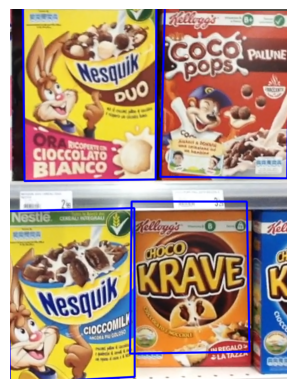

Scene: scenes/e4.png:
Product 0 - 1 instance found:
	Instance 3 {position: (158, 738), width: 323px, height: 444px}
Product 11 - 1 instance found:
	Instance 3 {position: (462, 692), width: 308px, height: 393px}
Product 25 - 1 instance found:
	Instance 3 {position: (555, 210), width: 326px, height: 451px}
Product 26 - 1 instance found:
	Instance 3 {position: (205, 195), width: 337px, height: 495px}




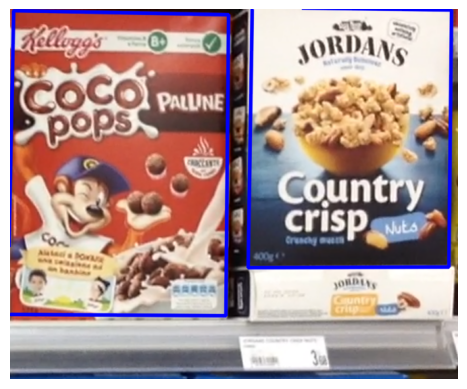

Scene: scenes/e5.png:
Product 19 - 1 instance found:
	Instance 3 {position: (503, 190), width: 296px, height: 386px}
Product 25 - 1 instance found:
	Instance 3 {position: (161, 229), width: 323px, height: 448px}




In [13]:
## Main Code for the STEP A solution.
def step_A(p_images, p_scenes, report_path, verbose=False):
        '''
        Given the image paths of many products and scenes, the function tries to find if the products are present in the scene
        and saves the search results in the file specified by the report_path argument.

        Args:
            p_images:       list of products images paths
            p_scenes:       list of scenes images paths
            report_path:    path for the textual report file
            verbose:        if True, it also prints the report on terminal
        '''

        ## specify the file path where to print a full report of the analysis
        if report_path is None:
            print("Error: You must specify a report path")
            return

        # the system object used to perform the search during Step A.
        system = Simple_Finder(p_images, use_flann=False)
        
        with open(report_path, 'w') as file:

            for path_scene in p_scenes:
                
                str, scene_bbox = system.analyze_scene(path_scene)
                
                r_str = "Scene: {}:\n".format(path_scene) + str
                file.write(r_str)
                file.write("\n\n")

                if verbose:
                    print_image(scene_bbox)
                    print(r_str)
                    print()

        return


paths_images = ['models/{}.jpg'.format(i) for i in {0,1,11,19,24,25,26}]
paths_scenes = ['scenes/e{}.png'.format(i) for i in {1,2,3,4,5}]

step_A(paths_images, paths_scenes, "report_step_A.txt", verbose=True)

### Step B - execution
The following code performs the main execution of the Step B activity. A report containing a description of each product found in every scene will be printed and saved on disk.

In [14]:
import os
if not os.path.exists("models_keypoints"):
    os.makedirs("models_keypoints")
if not os.path.exists("scenes_keypoints"):
    os.makedirs("scenes_keypoints")
if not os.path.exists("scenes_gray"):
    os.makedirs("scenes_gray")
if not os.path.exists("models_gray"):
    os.makedirs("models_gray")

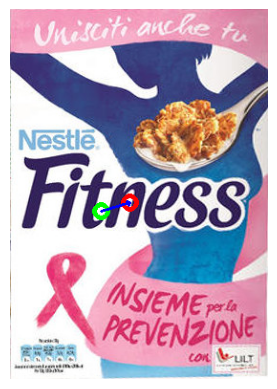

337.02161407470703
0.4481196320518163
[29.77839661 -9.63900757]


In [15]:

q_idx = good[idx].queryIdx
t_idx = good[idx].trainIdx

centroid_model = np.float32([ kp.pt for kp in md_kp ]).reshape(-1,1,2).mean(axis=0, dtype=np.int32)[0]

vect = centroid_model - kp_model[q_idx].pt

centroid_im = cv2.circle(model_im.copy(), centroid_model, 7, (0,0,255), 3)
centroid_im = cv2.circle(centroid_im, np.int32(kp_model[q_idx].pt), 7, (0,255,0), 3)
centroid_im = cv2.arrowedLine(centroid_im, np.int32(kp_model[q_idx].pt), np.int32(kp_model[q_idx].pt + vect), (255,0,0), 2)

print_image(centroid_im)

centroid_im2 = cv2.circle(scene_im.copy(), np.int32(kp_scene[t_idx].pt), 7, (0,255,0), 3)
p1_sc = np.int32(kp_scene[t_idx].pt)
scale_f = kp_scene[t_idx].size / kp_model[q_idx].size
rot_f = kp_scene[t_idx].angle - kp_model[q_idx].angle
rot_f = radians(rot_f)

print(degrees(rot_f))
print(scale_f)
print(vect)

#vect_r = np.float32([vect[0]*cos(rot_f),vect[1]*sin(rot_f)])

#print(vect_r)
centr_2 = np.int32(p1_sc + scale_f*vect)

centroid_im2 = cv2.arrowedLine(centroid_im2, p1_sc, centr_2, (255,0,0), 2)


In [16]:
class My_KeyPoint():
    def __init__(self, keypoint: cv2.KeyPoint, joining_vector):
        self.keypoint = keypoint
        self.vector = joining_vector


class Product_Model_GHT():
    
    def __init__(self, identificator, keypoints: list[cv2.KeyPoint], descriptors, hist):
        
        self.id = identificator
        self.set_centroid_and_vectors(keypoints)
        self.descriptors = descriptors
        self.hist = hist


    def set_centroid_and_vectors(self, keypoints: list[cv2.KeyPoint]):

        # calculate the reference point (barycenter)
        self.centroid = np.float32([ kp.pt for kp in keypoints ]).reshape(-1,1,2).mean(axis=0, dtype=np.int32)[0]
        
        # for each keypoint calculate the vector between it and the barycenter
        self.keypoints = []
        for kp in keypoints:
            vect = np.array(self.centroid - kp.pt)
            self.keypoints.append(My_KeyPoint(kp, vect))


class Hough_Accumulator():
    
    def __init__(self, train_image, bins_dx=100, bins_dy=50, bins_ds=5, bins_dtheta=4):
        
        width = train_image.shape[1]
        height = train_image.shape[0]
        
        dx_span = int(width / bins_dx)+1
        dx_range = [(x,x+dx_span) for x in np.arange(0, width, dx_span)]

        dy_span = int(height / bins_dy)+1
        dy_range = [(x,x+dy_span) for x in np.arange(0, height, dy_span)]
        
        s_max = 1.7
        s_min = 0.3
        ds_span = (s_max-s_min) / bins_ds 
        ds_range = [(x,x+ds_span) for x in np.arange(s_min, s_max, ds_span)]

        r_max = 360
        r_min = 0
        dt_span = (r_max-r_min) / bins_dtheta
        dt_range = [(x,x+dt_span) for x in np.arange(-180, 180, dt_span)]

        self.dx_range = dx_range
        self.dy_range = dy_range
        self.ds_range = ds_range
        self.dt_range = dt_range
        
        self.dx_span = dx_span
        self.dy_span = dy_span
        self.ds_span = ds_span
        self.dt_span = dt_span

        self.bins_dx = bins_dx
        self.bins_dy = bins_dy
        self.bins_ds = bins_ds
        self.bins_dt = bins_dtheta
        self.accumulator = np.zeros((bins_dy, bins_dx, bins_ds, bins_dtheta), dtype=np.int32)


    def reset(self):
        self.accumulator = np.zeros((self.bins_dy, self.bins_dx, self.bins_ds, self.bins_dt), dtype=np.int32)


    def get_bin(self, val, bins_range):
        
        idx = 0
        for min,max in bins_range:
            if val >= min and val < max:
                #print("min:{},max:{},val:{}".format(min,max,val))
                return idx
            idx += 1
        
        if val < bins_range[0][0]:
            return 0
        else:
            return len(bins_range)-1


    def accumulate(self, query: My_KeyPoint, train: cv2.KeyPoint):
        
        vect = query.vector  # joining vector: from keypoint to reference point
        
        query = query.keypoint
        train = train

        scale_f = train.size / query.size

        rot_f = train.angle - query.angle
        rot_f = radians(rot_f)
        
        ccos = cos(rot_f)
        ssin = sin(rot_f)
        rotation = np.float32([[ccos, ssin],[-ssin,ccos]])

        c = np.int32(train.pt + rotation.dot(scale_f*vect))
 
        x = self.get_bin(c[0], self.dx_range)
        y = self.get_bin(c[1], self.dy_range)
        
        s = self.get_bin(scale_f, self.ds_range)
        r = self.get_bin(rot_f, self.dt_range)
        
        self.accumulator[y,x,s,r] += 1
        return (y,x,s,r)
    
    
    def clean_neighborhood(self, acc_point):
        near_moves = list(itertools.product(set(range(-6,7,1)), repeat = 4))
        near_bins = np.array(near_moves) + np.array(acc_point)

        for bin in near_bins:
            if self.is_in_bounds(bin):
                y,x,s,r = bin
                self.accumulator[y,x,s,r] = 0


    def is_in_bounds(self, point):
        y,x,s,r = point
        if y >= 0 and y < self.bins_dy:
            if x >= 0 and x < self.bins_dx:
                if s >= 0 and s < self.bins_ds:
                    if r >= 0 and r < self.bins_dt:
                        return True
        return False
    

def get_keypoints_and_descriptors_prod_B(paths_im, sift, mask=None):
    '''
    Given a list of image paths and a mask, the method detects the keypoints and compute
    their descriptors. It returns a specific tuple.

    Args:
        paths_im:   paths of the images
        mask:       mask that filters the space in which to search for keypoints

    Returns:
        prod_st:    list of tuples - (product_id, keypoint, description)
                        the product_id is extracted by the image filename.
        images:     list of the images read by disk
    '''

    if sift is None:
        # create the SIFT object and the Flann matcher
        sift = cv2.SIFT_create()

    prod_st = []        # empty list for the informations (id, keypoints, description)
    images = []         # empty list for the images
    for path in paths_im:
        im = cv2.imread(path)
        width = int(im.shape[1])
        height = int(im.shape[0])
        width_to_height = width/height
        height = 400
        width = int(width_to_height*height)
        resized_dim = (width, height)
        
        # resize image
        im = cv2.resize(im, resized_dim, interpolation = cv2.INTER_AREA)
    
        '''if im.shape[0] > 600:
            scale_percent = 25 # percent of original size
            width = int(im.shape[1] * scale_percent / 100)
            height = int(im.shape[0] * scale_percent / 100)
            resized_dim = (width, height)
            
            # resize image
            im = cv2.resize(im, resized_dim, interpolation = cv2.INTER_AREA)
            '''
        images.append(im)

        kp, des = sift.detectAndCompute(im, mask)
        product_id = extract_id_from_path(path)
        
        # append to the list a tuple that describes the product
        prod_st.append([product_id, kp, des])
    
    return prod_st, images

In [83]:
class Multi_Finder():

    def __init__(self, paths_im, use_flann=False, use_orb=False, normalize_hist=False):
        '''
        Saves the images and their descriptors (id, kp, des) in local structures, to improve the 
        reusability of the data during the detection process. It also initialize the Flann matcher.
        '''
        if use_flann:
            self.matcher = self.initialize_flann()
        else:
            self.matcher = cv2.BFMatcher()
        if use_orb:
            orb = cv2.ORB_create(nfeatures=1400, scaleFactor=1.2, nlevels=10, edgeThreshold=15, WTA_K=3, patchSize=10, fastThreshold=10)
            self.sift_m = orb
            orb_s = cv2.ORB_create(nfeatures=20000, scaleFactor=1.2, nlevels=10, edgeThreshold=15, WTA_K=3, patchSize=10, fastThreshold=5)
            self.sift_s = orb_s
        else:
            sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=8, contrastThreshold=0.06, edgeThreshold=14, sigma=1.9)
            #self.sift_m = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=10, sigma=2.6)
            self.sift_m = sift
            self.sift_s = cv2.SIFT_create(nOctaveLayers=8, contrastThreshold=0.06, edgeThreshold=15, sigma=1.6)
            #self.sift_s = sift
        self.lowe_ratio_distance = 0.85
        self.MIN_MATCH_COUNT = 16
        self.MIN_MATCH_PERC = 0.1
        self.hist_size = 180
        self.similarity_th = 0.25
        self.use_percent_threshold = False
        self.normalize_hist = normalize_hist
        
        prods_st, self.images = get_keypoints_and_descriptors_prod_B(paths_im, self.sift_m, mask=None)
        for prod in prods_st:
            print("id:{} - n° keypoints:{}".format(prod[ID], len(prod[KP])))
        
        for i in range(len(self.images)):
            hsv = cv2.cvtColor(self.images[i], cv2.COLOR_BGR2HSV)
            #hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0, 180, 0, 256])
            hist = cv2.calcHist([hsv], [0], None, [180], [0, 180])
            hist = cv2.normalize(hist, hist, norm_type=cv2.NORM_L1) if normalize_hist else hist
            prods_st[i].append(hist)
            
        
        sift_paths = ["models_keypoints/{}.jpg".format(extract_id_from_path(filepath)) for filepath in paths_im]
        gray_paths = ["models_gray/{}.jpg".format(extract_id_from_path(filepath)) for filepath in paths_im]
        
        for sift_p, gray_p, image, prod in zip(sift_paths, gray_paths, self.images, prods_st):
            image_with_keypoints = cv2.drawKeypoints(image,prod[KP],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            cv2.imwrite(sift_p, image_with_keypoints)
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(gray_p, image_gray)
        
        self.prods_st = [Product_Model_GHT(prod[ID], prod[KP], prod[DES], prod[HUE]) for prod in prods_st] 


    def initialize_flann(self):
        '''Initializes the flann matcher with some default parameters'''
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 8)
        search_params = dict(checks = 100)
        return cv2.FlannBasedMatcher(index_params, search_params)


    def remove_used_kp(self, kp, des, kp_to_remove):
#        kp_to_remove = [good_kp[i].trainIdx for i in range(len(good_kp))]
        new_kp_st = []
        new_des_st = np.ndarray(shape=(des.shape[0]-len(kp_to_remove), des.shape[1]), dtype=des.dtype)
        count = 0
        #print(kp_to_remove)
        for i in range(len(des)):
            if i in kp_to_remove: 
                #print(i)
                count += 1
            else: 
                new_kp_st.append(kp[i])
                new_des_st[i-count] = des[i]
        #print("deleted: {}".format(count))
        new_kp_st = tuple(new_kp_st)
        return new_kp_st, new_des_st


    def get_keypoints_and_descriptors(self, scene, sift, mask=None):
        '''
        Given a list of image paths and a mask, the method detects the keypoints and compute
        their descriptors. It returns a specific tuple.

        Args:
            paths_im:   paths of the images
            mask:       mask that filters the space in which to search for keypoints

        Returns:
            prod_st:    list of tuples - (product_id, keypoint, description)
                            the product_id is extracted by the image filename.
            images:     list of the images read by disk
        '''
   
        kp, des = sift.detectAndCompute(scene, mask)
        
        return kp, des

    def find_match(self, product_st: Product_Model_GHT, prod_im, scene_kp, scene_des, scene_im):
        '''
        Given the KEYPOINTS the function tries to find if the model is present in the train image

        Args:
            product_st:     the structure (id,kp,des) of the products
            scene:          the structure (id,kp,des) of the scene
            image:          product's image

        Returns:
            r_list:         list of coordinates of products mapped in the scene
        '''
        print("model: {}".format(product_st.id))
        r_list = []
        # scene_kp, scene_des = sift.detectAndCompute(scene_im, scene_mask)

        h_sc = scene_im.shape[0]
        w_sc = scene_im.shape[1]
        accumulator = Hough_Accumulator(scene_im,
                                        bins_dx=int(w_sc*0.04),
                                        bins_dy=int(h_sc*0.04),
                                        bins_ds=5,
                                        bins_dtheta=1)
        accumulators = []

        # Matching the descriptors
        matches = self.matcher.knnMatch(product_st.descriptors,scene_des,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < self.lowe_ratio_distance*n.distance:
                good.append(m)

        more = True

        keypoints_in_bins = dict()
        for i in range(len(good)):
            prod_kp = product_st.keypoints[good[i].queryIdx]
            scen_kp = scene_kp[good[i].trainIdx]
            
            bin = accumulator.accumulate(prod_kp, scen_kp)
            if bin in keypoints_in_bins.keys():
                #keypoints_in_bins.get(bin).append((match.queryIdx, match.trainIdx))
                '''p_list, s_list = keypoints_in_bins.get(bin)
                p_list.append(prod_kp.keypoint.pt)
                s_list.append(scen_kp.pt)'''
                keypoints_in_bins.get(bin).append(i)
            else:
                #keypoints_in_bins[bin] = [(match.queryIdx, match.trainIdx)]
                '''p_list = [prod_kp.keypoint.pt]
                s_list = [scen_kp.pt]
                keypoints_in_bins[bin] = [p_list, s_list]'''
                keypoints_in_bins[bin] = [i]
        kp = scene_kp
        des = scene_des
        while(more):
            
            #accumulator.reset()
            #accumulators.append(accumulator.accumulator)
            max_point = np.unravel_index(accumulator.accumulator.argmax(), accumulator.accumulator.shape)

            match_ids = keypoints_in_bins.get(max_point)

            needed_kps = int(len(product_st.keypoints)*self.MIN_MATCH_PERC)+1
            if not self.use_percent_threshold:
                needed_kps = self.MIN_MATCH_COUNT
            
            if match_ids is None or len(match_ids) < 4 or len(match_ids) < needed_kps: more = False
            
            print("-- point: {}, numpoints: {}, needed: {}, more: {}".format(max_point, len(match_ids) if match_ids is not None else "[]", needed_kps, more))
            if more:
                keypoints_in_bins.get(max_point)
                src_pts = [product_st.keypoints[good[id].queryIdx].keypoint.pt for id in match_ids] 
                dst_pts = [kp[good[id].trainIdx].pt for id in match_ids]
                #src_pts, dst_pts = pts_st
                src_pts = np.float32(src_pts).reshape(-1,1,2)
                dst_pts = np.float32(dst_pts).reshape(-1,1,2)
                
                # Calculating homography based on correspondences
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                
                # Apply homography to project corners of the query image into the image
                h,w = prod_im.shape[0:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)
                #print("shape: {}".format(np.int32(dst)))
                
                
                mask = np.zeros_like(scene_im[:,:,0])
                #mask = cv2.polylines(mask,[np.int32(dst)],True,255,3, cv2.LINE_AA)
                mask = cv2.fillPoly(mask,[np.int32(dst)],255, cv2.LINE_AA)
                
                # Drawing bounding box
                hsv = cv2.cvtColor(scene_im, cv2.COLOR_BGR2HSV)
                #sc_hist = cv2.calcHist([hsv], [0,1], mask, [180, 256], [0,180,0,256])
                sc_hist = cv2.calcHist([hsv], [0], mask, [180], [0,180])
                if self.normalize_hist:
                    sc_hist = cv2.normalize(sc_hist, sc_hist, norm_type=cv2.NORM_L1)
                #print("hist shape {}".format(sc_hist.shape))
                #print(sc_hist)
                pr_hist = product_st.hist.flatten()
                sc_hist = sc_hist.flatten()
                similarity = np.dot(pr_hist, sc_hist) / (np.linalg.norm(pr_hist) * np.linalg.norm(sc_hist))
                print(similarity)
                if similarity > self.similarity_th:
                    r_list.append(dst)
                    #print("kp len: {}, des len: {}".format(len(scene_kp), len(scene_des)))
                    kp, des = self.remove_used_kp(kp, des, np.unique([good[i].trainIdx for i in match_ids]))
                    #print("kp cle: {}, des cle: {}".format(len(scene_kp), len(scene_des)))    
                else:
                    print("---> rejected")
                accumulator.clean_neighborhood(max_point)
        return r_list, kp, des, accumulators

    
    def analyze_scene(self, scene_kp, scene_des, scene_im):
        '''
        Given the path of a scene, the function searches for 
        the products in the scene by calling find_match().

        Args:
            path_scene: optional - paths of the scene image source

        Returns:
            description:    a string description of which products were found in the scene
            scene_bbox:     the scene image with the bounding box around the detected products
        '''
        
        ## create a string for the final report
        str = ""
        
        # scene image with products bounding box
        scene_bbox = scene_im.copy()
        accumulators = []
        
        for i in range(len(self.images)):
            
            # search for a single product in the scene
            instances, scene_kp, scene_des, accumulators = self.find_match(self.prods_st[i], self.images[i], scene_kp, scene_des, scene_im)
            instance_count = 0
            if len(instances) > 0:
                str += "Product {} - {} instance found:\n".format(self.prods_st[i].id, len(instances))
    
            for points in instances:
                # Drawing bounding box
                
                scene_bbox = cv2.polylines(scene_bbox,[np.int32(points)],True,(255,0,0),3, cv2.LINE_AA)
                #scene_bbox = cv2.polylines(scene_bbox,np.int32([[[0,0]],[[0,50]],[[50,50]],[[50,0]]]),True,(255,0,0),3, cv2.LINE_AA)
                found_pos = extract_product_position(points)
                
                str += "\tInstance {} {{position: {}, width: {}px, height: {}px}}\n".format(instance_count, found_pos[CENTER], found_pos[WIDTH], found_pos[HEIGHT])
                instance_count += 1

        return str, scene_bbox, accumulators


id:0 - n° keypoints:972
id:1 - n° keypoints:883
id:11 - n° keypoints:822
id:19 - n° keypoints:1158
id:24 - n° keypoints:1133
id:25 - n° keypoints:1323
id:26 - n° keypoints:1340
model: 0
-- point: (6, 36, 1, 0), numpoints: 17, needed: 16, more: True
0.22839586
---> rejected
-- point: (14, 54, 2, 0), numpoints: 2, needed: 16, more: False
model: 1
-- point: (9, 48, 2, 0), numpoints: 11, needed: 16, more: False
model: 11
-- point: (9, 48, 3, 0), numpoints: 12, needed: 16, more: False
model: 19
-- point: (0, 54, 4, 0), numpoints: 6, needed: 16, more: False
model: 24
-- point: (9, 7, 3, 0), numpoints: 96, needed: 16, more: True
0.400099
-- point: (9, 21, 3, 0), numpoints: 75, needed: 16, more: True
0.4699701
-- point: (6, 14, 2, 0), numpoints: 2, needed: 16, more: False
model: 25
-- point: (9, 49, 2, 0), numpoints: 69, needed: 16, more: True
0.40295652
-- point: (0, 54, 2, 0), numpoints: 4, needed: 16, more: False
model: 26
-- point: (8, 35, 3, 0), numpoints: 120, needed: 16, more: True
0.40

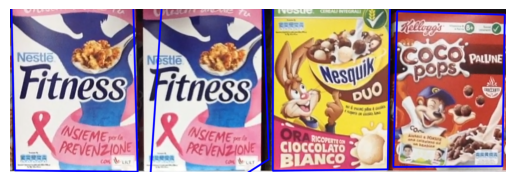

Scene: scenes/m1.png:
Product 24 - 2 instance found:
	Instance 0 {position: (184, 214), width: 352px, height: 503px}
	Instance 1 {position: (574, 236), width: 416px, height: 693px}
Product 25 - 1 instance found:
	Instance 0 {position: (1261, 231), width: 313px, height: 445px}
Product 26 - 1 instance found:
	Instance 0 {position: (921, 218), width: 330px, height: 490px}


model: 0
-- point: (11, 7, 3, 0), numpoints: 110, needed: 16, more: True
0.26580372
-- point: (0, 16, 4, 0), numpoints: 1, needed: 16, more: False
model: 1
-- point: (10, 19, 2, 0), numpoints: 48, needed: 16, more: True
0.29755816
-- point: (10, 32, 2, 0), numpoints: 46, needed: 16, more: True
0.8060721
-- point: (10, 45, 2, 0), numpoints: 20, needed: 16, more: True
0.65258056
-- point: (0, 5, 3, 0), numpoints: 1, needed: 16, more: False
model: 11
-- point: (9, 19, 2, 0), numpoints: 23, needed: 16, more: True
0.7485848
-- point: (10, 45, 2, 0), numpoints: 16, needed: 16, more: True
0.19037633
---> rejected
-- point: (1

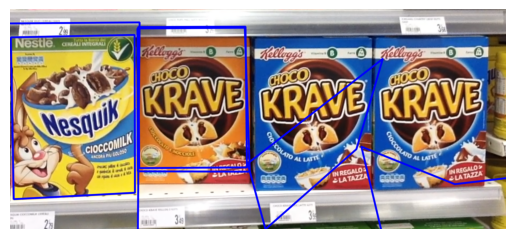

Scene: scenes/m2.png:
Product 0 - 1 instance found:
	Instance 0 {position: (178, 299), width: 340px, height: 453px}
Product 1 - 3 instance found:
	Instance 0 {position: (511, 247), width: 302px, height: 395px}
	Instance 1 {position: (849, 395), width: 479px, height: 190px}
	Instance 2 {position: (1266, 531), width: 281px, height: 443px}
Product 11 - 1 instance found:
	Instance 0 {position: (511, 254), width: 313px, height: 399px}
Product 26 - 1 instance found:
	Instance 0 {position: (130, 345), width: 433px, height: 630px}


model: 0
-- point: (5, 9, 2, 0), numpoints: 37, needed: 16, more: True
0.21359149
---> rejected
-- point: (0, 0, 4, 0), numpoints: 1, needed: 16, more: False
model: 1
-- point: (8, 33, 2, 0), numpoints: 10, needed: 16, more: False
model: 11
-- point: (9, 21, 3, 0), numpoints: 6, needed: 16, more: False
model: 19
-- point: (7, 47, 2, 0), numpoints: 137, needed: 16, more: True
0.51506203
-- point: (11, 9, 4, 0), numpoints: 2, needed: 16, more: False
model: 24
-- poin

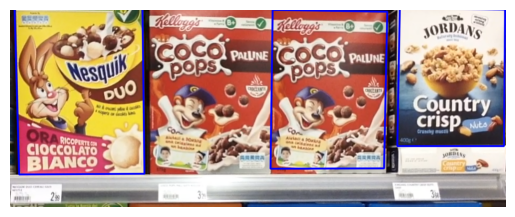

Scene: scenes/m3.png:
Product 19 - 1 instance found:
	Instance 0 {position: (1232, 189), width: 297px, height: 386px}
Product 25 - 1 instance found:
	Instance 0 {position: (889, 224), width: 317px, height: 442px}
Product 26 - 1 instance found:
	Instance 0 {position: (195, 206), width: 350px, height: 510px}


model: 0
-- point: (5, 36, 2, 0), numpoints: 15, needed: 16, more: False
model: 1
-- point: (8, 48, 2, 0), numpoints: 5, needed: 16, more: False
model: 11
-- point: (7, 48, 2, 0), numpoints: 4, needed: 16, more: False
model: 19
-- point: (0, 40, 4, 0), numpoints: 2, needed: 16, more: False
model: 24
-- point: (8, 21, 3, 0), numpoints: 85, needed: 16, more: True
0.40876752
-- point: (8, 6, 3, 0), numpoints: 55, needed: 16, more: True
0.289278
-- point: (0, 0, 4, 0), numpoints: 4, needed: 16, more: False
model: 25
-- point: (9, 49, 3, 0), numpoints: 41, needed: 16, more: True
0.31420586
-- point: (8, 61, 2, 0), numpoints: 35, needed: 16, more: True
0.28364044
-- point: (0, 68, 3, 0),

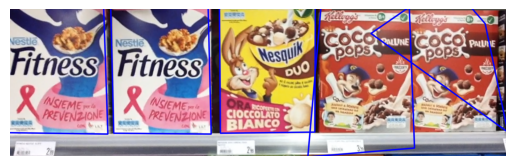

Scene: scenes/m4.png:
Product 24 - 2 instance found:
	Instance 0 {position: (539, 196), width: 348px, height: 502px}
	Instance 1 {position: (160, 190), width: 361px, height: 508px}
Product 25 - 2 instance found:
	Instance 0 {position: (1264, 248), width: 383px, height: 548px}
	Instance 1 {position: (1585, 119), width: 205px, height: 334px}
Product 26 - 1 instance found:
	Instance 0 {position: (921, 195), width: 337px, height: 497px}


model: 0
-- point: (25, 13, 2, 0), numpoints: 2, needed: 16, more: False
model: 1
-- point: (28, 18, 2, 0), numpoints: 37, needed: 16, more: True
0.8320425
-- point: (28, 5, 2, 0), numpoints: 23, needed: 16, more: True
0.29694793
-- point: (28, 31, 2, 0), numpoints: 19, needed: 16, more: True
0.55609435
-- point: (0, 6, 4, 0), numpoints: 3, needed: 16, more: False
model: 11
-- point: (27, 5, 2, 0), numpoints: 21, needed: 16, more: True
0.7310261
-- point: (27, 31, 2, 0), numpoints: 15, needed: 16, more: False
model: 19
-- point: (7, 35, 2, 0), numpoints: 

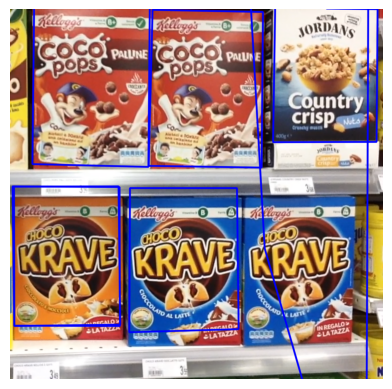

Scene: scenes/m5.png:
Product 1 - 3 instance found:
	Instance 0 {position: (500, 720), width: 315px, height: 415px}
	Instance 1 {position: (163, 711), width: 305px, height: 400px}
	Instance 2 {position: (857, 232), width: 1055px, height: 1657px}
Product 11 - 1 instance found:
	Instance 0 {position: (162, 711), width: 303px, height: 400px}
Product 19 - 1 instance found:
	Instance 0 {position: (908, 190), width: 297px, height: 387px}
Product 25 - 2 instance found:
	Instance 0 {position: (566, 229), width: 325px, height: 449px}
	Instance 1 {position: (233, 221), width: 334px, height: 456px}




In [84]:
## TESTING STEP B BEHAVIOUR
def step_B(p_images, p_scenes, report_path, verbose=False):
        '''
        Given the image paths of many products and scenes, the function tries to find if the products are present in the scene
        and saves the search results in the file specified by the report_path argument.

        Args:
            p_images:       list of products images paths
            p_scenes:       list of scenes images paths
            report_path:    path for the textual report file
            verbose:        if True, it also prints the report on terminal
        '''

        ## specify the file path where to print a full report of the analysis
        if report_path is None:
            print("Error: You must specify a report path")
            return

        # the system object used to perform the search during Step B.
        system = Multi_Finder(p_images, use_flann=False, use_orb=False, normalize_hist=False)
        acc0 = []
        i = 0
        with open(report_path, 'w') as file:

            for path_scene in p_scenes:
                
                # get the keypoints and descriptors of the scene image
                scene_st, scene_im = get_keypoints_and_descriptors([path_scene], system.sift_s, None)
                # the method provides a list, but we analyze one image -> get the first element.
                scene_st = scene_st[0]
                scene_im = scene_im[0]

                sift_path = "scenes_keypoints/{}.png".format(extract_id_from_path(path_scene))
                gray_path = "scenes_gray/{}.png".format(extract_id_from_path(path_scene))
        
                image_with_keypoints = cv2.drawKeypoints(scene_im,scene_st[KP],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                cv2.imwrite(sift_path, image_with_keypoints)
                image_gray = cv2.cvtColor(scene_im, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(gray_path, image_gray)
                
                str, scene_bbox, acc = system.analyze_scene(scene_st[KP], scene_st[DES], scene_im)
                if i == 0:
                     acc0 = acc
                r_str = "Scene: {}:\n".format(path_scene) + str
                file.write(r_str)
                file.write("\n\n")

                if verbose:
                    print_image(scene_bbox)
                    print(r_str)
                    print()
                i += 1

        return acc0


paths_images = ['models/{}.jpg'.format(i) for i in {0,11,1,19,24,25,26}]
paths_scenes = ['scenes/m{}.png'.format(i) for i in {1,2,3,4,5}]

acc0 = step_B(paths_images, paths_scenes, "report_step_B.txt", verbose=True)